## 1.Load the beans dataset.

In [1]:
#import tensorflow as tf
import tensorflow.compat.v2 as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from __future__ import absolute_import, division, print_function, unicode_literals
from collections import Counter
# Enable eager execution
tf.enable_v2_behavior()

## load the dataset

Please install tensorflow_datasets packages using

pip install tensorflow_datasets

In [2]:

%%time
import importlib

def import_or_install(library):
    try:
        importlib.import_module(library)
        print(f"{library} is already installed.")
    except ImportError:
        print(f"{library} is not installed. Installing...")
        !pip install {library}
        print(f"{library} has been successfully installed.")

# Example usage:
libraries_to_check = ["tensorflow_datasets"]

for library in libraries_to_check:
    import_or_install(library)

tensorflow_datasets is already installed.
CPU times: total: 672 ms
Wall time: 803 ms


In [3]:
import tensorflow_datasets as tfds

(bn_train, bn_validation, bn_test),bn_info = tfds.load(

    name = 'beans',

    split = ['train', 'validation', 'test'],

    as_supervised = True,

    with_info = True)

print(bn_info)

tfds.core.DatasetInfo(
    name='beans',
    full_name='beans/0.1.0',
    description="""
    Beans is a dataset of images of beans taken in the field using smartphone
    cameras. It consists of 3 classes: 2 disease classes and the healthy class.
    Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated by
    experts from the National Crops Resources Research Institute (NaCRRI) in Uganda
    and collected by the Makerere AI research lab.
    """,
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    data_dir='C:\\Users\\yliu3\\tensorflow_datasets\\beans\\0.1.0',
    file_format=tfrecord,
    download_size=171.69 MiB,
    dataset_size=171.63 MiB,
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=128, num_shards=1>,
        '

In [4]:
# the training dataset has features/image and label/target
for image, label in bn_train.take(1):  # example is (image, label)
  print(image.shape, label)
  

(500, 500, 3) tf.Tensor(1, shape=(), dtype=int64)


In [5]:
print(bn_info.features["label"].num_classes)
print(bn_info.features["label"].names)

3
['angular_leaf_spot', 'bean_rust', 'healthy']


In [6]:
print(bn_info.features.shape)
print(bn_info.features.np_dtype)
print(bn_info.features['image'].shape)
print(bn_info.features['image'].np_dtype)

{'image': (500, 500, 3), 'label': ()}
{'image': <class 'numpy.uint8'>, 'label': <class 'numpy.int64'>}
(500, 500, 3)
<class 'numpy.uint8'>


In [7]:
import tensorflow as tf
from tensorflow.data import Dataset

# Assuming you have a pre-loaded image dataset `image_dataset`

# Convert dataset to a NumPy array (images and labels)
data_array = tfds.as_numpy(bn_train)

for imgs, labels in data_array:
    print (imgs.shape, labels.shape)
    break

(500, 500, 3) ()


In [8]:

# Image parameters:
image_height = 500
image_width = 500
num_channels = 3 # RGB
num_classes = 3 # healthy, angular leaf spot disease, bean rust disease

# Pipeline hyperparameters:
batch_size = 32

# Let's keep the dimensions the same (no resizing for now)
# the inputs are the image, label and target size
def normalize_image(image, label, target_height = 500, target_width = 500):
    """Normalizes images: `unit8` -> `float32` and resizes images
    by keeping the aspect ratio the same without distortion."""
    image = tf.cast(image, tf.float32)/255.
    image = tf.image.resize_with_crop_or_pad(image, target_height, target_width)
    return image, label
#apply normalize_image() function to each of image avoid writing a loop
bn_train = bn_train.map(normalize_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
bn_train = bn_train.cache().shuffle(1000)
bn_train = bn_train.shuffle(bn_info.splits['train'].num_examples)
bn_train = bn_train.batch(batch_size)
bn_train = bn_train.prefetch(tf.data.experimental.AUTOTUNE)


Perform the similar tasks for the validation dataset

In [9]:
bn_validation = bn_validation.map(
    normalize_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
bn_validation = bn_validation.batch(batch_size)
bn_validation = bn_validation.cache()
bn_validation = bn_validation.prefetch(tf.data.experimental.AUTOTUNE)

bn_test = bn_test.map(
    normalize_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
bn_test = bn_test.batch(batch_size)
bn_test = bn_test.cache()
bn_test = bn_test.prefetch(tf.data.experimental.AUTOTUNE)

In [10]:
def return_class_labels(ds):
    """"Returns a list of class labels from a `DatasetV1Adapter` object."""
    l_labels = []
    # since we handle labels only in this funciton, we discard the first parameter that is image
    # we take out one batch that is 32 images and lables
    for _, labels in ds.take(-1):
        labels = labels.numpy()
        l_labels.append(labels[:])
    # the l_labels is a nest of list , for example [ [1, 0, 2, ...], [2,1, 1,..], ..]
    # return a single list by using list comprehension
    #[1, 0, 2, ..., 2, 1, 1, ..]
    return [item for sublist in l_labels for item in sublist]

training_labels = return_class_labels(bn_train)
print("The distribution of training labels is: ", (Counter(training_labels)))

validation_labels = return_class_labels(bn_validation)
print("The distribution of validation labels is: ", (Counter(validation_labels)))

test_labels = return_class_labels(bn_test)
print("The distribution of test labels is: ", (Counter(test_labels)))

The distribution of training labels is:  Counter({1: 348, 0: 345, 2: 341})
The distribution of validation labels is:  Counter({1: 45, 2: 44, 0: 44})
The distribution of test labels is:  Counter({0: 43, 1: 43, 2: 42})


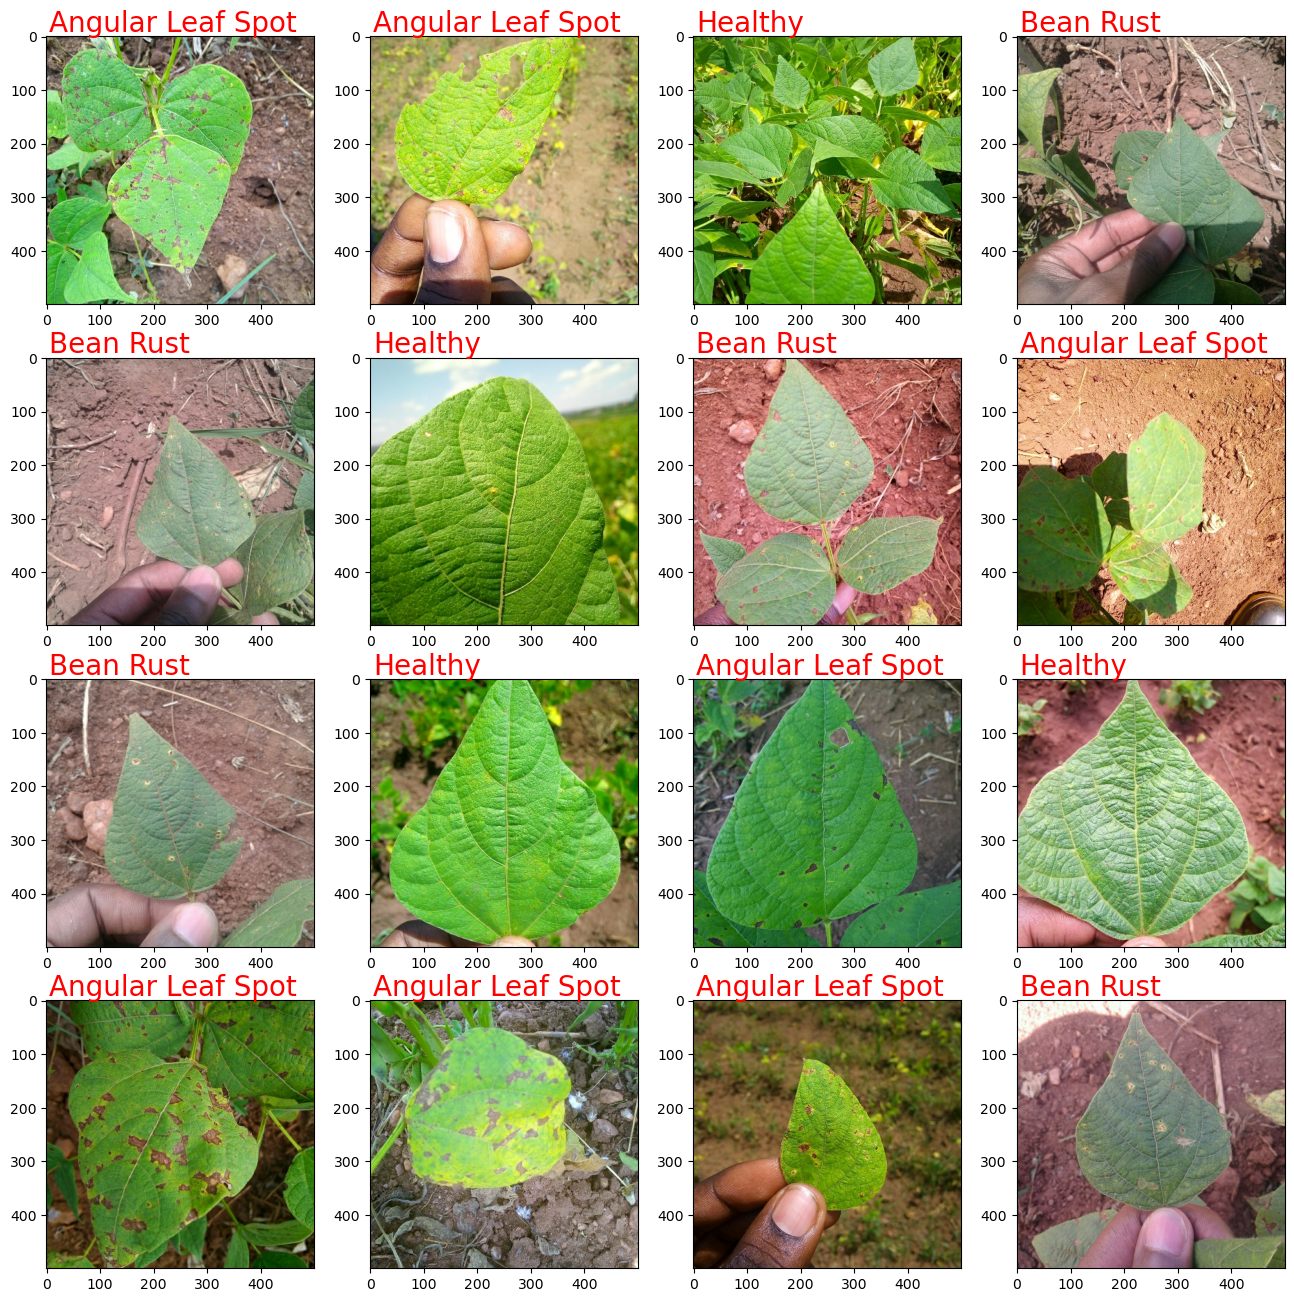

In [11]:
# take out one batch that is 32 images
example = bn_train.take(1)
# each batch has two componets, image and label
# sample=(image, lable)
for sample in example:
    image, label = sample[0], sample[1]
    #convert them to np
    image = image.numpy()
    label = label.numpy()

n_cols, n_rows = 4, 4
plt.rcParams['figure.figsize'] = [n_cols*4, n_rows*4]

fig = plt.figure()
for i in range(1, n_cols*n_rows + 1):
    ax = fig.add_subplot(n_rows, n_cols,i)
    # we label the subplots using names instead of magic numbers such as 0, 1 and 2
    ax.text(5, -9, "Angular Leaf Spot" if label[i] == 0 else "Bean Rust" if label[i] == 1 else "Healthy",
            color = 'red', fontsize = 20)
    ax.imshow(image[i, :, :, :], cmap = plt.get_cmap("jet"))  

## Convert TensorFlow Dataset to Numpy Array to Inspect the Pixel Values

In [12]:
import tensorflow as tf
from tensorflow.data import Dataset


# Convert dataset to a NumPy array (images and labels)
image_array = tfds.as_numpy(bn_train)

for img in image_array:
    print (imgs.shape)
    break

(500, 500, 3)


In [13]:
img[0]

array([[[[0.3882353 , 0.24705882, 0.19215687],
         [0.49019608, 0.34117648, 0.2901961 ],
         [0.53333336, 0.38039216, 0.32156864],
         ...,
         [0.45882353, 0.3137255 , 0.21176471],
         [0.5176471 , 0.37254903, 0.27058825],
         [0.47843137, 0.33333334, 0.23137255]],

        [[0.42352942, 0.27450982, 0.22352941],
         [0.5686275 , 0.41960785, 0.36862746],
         [0.6156863 , 0.4509804 , 0.40392157],
         ...,
         [0.48235294, 0.3372549 , 0.23529412],
         [0.42352942, 0.27450982, 0.18431373],
         [0.39607844, 0.2509804 , 0.14901961]],

        [[0.5058824 , 0.3372549 , 0.3019608 ],
         [0.5568628 , 0.39215687, 0.34509805],
         [0.6156863 , 0.4509804 , 0.40392157],
         ...,
         [0.5372549 , 0.3764706 , 0.2901961 ],
         [0.5019608 , 0.34117648, 0.2627451 ],
         [0.5058824 , 0.34509805, 0.25882354]],

        ...,

        [[0.39607844, 0.20784314, 0.12941177],
         [0.4       , 0.21568628, 0.13725491]

In [14]:

print(f'The maximum value of pixels = {np.amax(img[0])}; the minimum value of pixels ={np.amin(img[0])}' )

The maximum value of pixels = 1.0; the minimum value of pixels =0.0


In [15]:
input_shape =imgs.shape
input_shape

(500, 500, 3)

In [16]:
model = models.Sequential()
# Get the image size using codes instead of using magic number (32,32,3)
input_shape =imgs.shape
print(f'The input shape = {input_shape}')
# The first Convolution layer has 32 filters, with the output has 32 channels. The size of the filter is 3*3
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape= input_shape))
# Followed by 2*2 pooling window 
model.add(layers.MaxPooling2D((2, 2)))
# The second Convolution layer has 64 filters, with the output has 64 channels. The size of the filter is 3*3
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# Followed by 2*2 pooling window 
model.add(layers.MaxPooling2D((2, 2)))
# The second Convolution layer has 64 filters, with the output has 64 channels. The size of the filter is 3*3
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# The Third Convolution layer has 64 filters, with the output has 64 channels. The size of the filter is 2*2
model.add(layers.Conv2D(64, (2, 2), activation='relu'))

The input shape = (500, 500, 3)
